### Original

Tải bộ dữ liệu WELFake

In [1]:
!gdown 1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3

Downloading...
From (original): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3
From (redirected): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3&confirm=t&uuid=a36ba4cd-4a1c-454c-a3e3-d526dee0ff43
To: /content/WELFake_Dataset.csv
100% 245M/245M [00:07<00:00, 34.0MB/s]


In [2]:
import pandas as pd

df = pd.read_csv("/content/WELFake_Dataset.csv")
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


Xóa các kí tự null và nối cột title vào cột test

In [3]:
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0
4,4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1
5,5,About Time! Christian Group Sues Amazon and SP...,About Time! Christian Group Sues Amazon and SP...,1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,Russians steal research on Trump in hack of U....,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,WATCH: Giuliani Demands That Democrats Apolog...,1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,Trump tussle gives unpopular Mexican leader mu...,0


In [4]:
import gensim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

Word2Vec

In [5]:
X = df['text']
y = df['label']

sentences = [sentence.split() for sentence in X]

embedding_dim = 100
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key, start=1)}
X_encoded = [[word_index[word] for word in sentence if word in word_index] for sentence in sentences]

max_len = 200
X_pad = pad_sequences(X_encoded, maxlen=max_len, padding='post')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_train.shape
X_test.shape

(14308, 200)

In [7]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (805862, 100)


Xây dựng mô hình 

In [8]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      80,586,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,586,200 (307.41 MB)

 Trainable params: 80,586,200 (307.41 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện mô hình 

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 72s 67ms/step - accuracy: 0.8211 - loss: 0.6239 - val_accuracy: 0.9609 - val_loss: 0.1162
Epoch 2/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 75s 68ms/step - accuracy: 0.9687 - loss: 0.0978 - val_accuracy: 0.9776 - val_loss: 0.0732
Epoch 3/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9902 - loss: 0.0382 - val_accuracy: 0.9758 - val_loss: 0.0705
Epoch 4/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.9972 - loss: 0.0142 - val_accuracy: 0.9784 - val_loss: 0.0845
Epoch 5/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9988 - loss: 0.0076 - val_accuracy: 0.9727 - val_loss: 0.1203
Epoch 6/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9987 - loss: 0.0074 - val_accuracy: 0.9789 - val_loss: 0.1055
Epoch 7/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.9990 - loss: 0.0055 - val_accuracy: 0.9727 - val_loss: 0.1437
Epoch 8/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.9991 - loss: 0.0053 - 

Vẽ đồ thị học accuracy và loss 

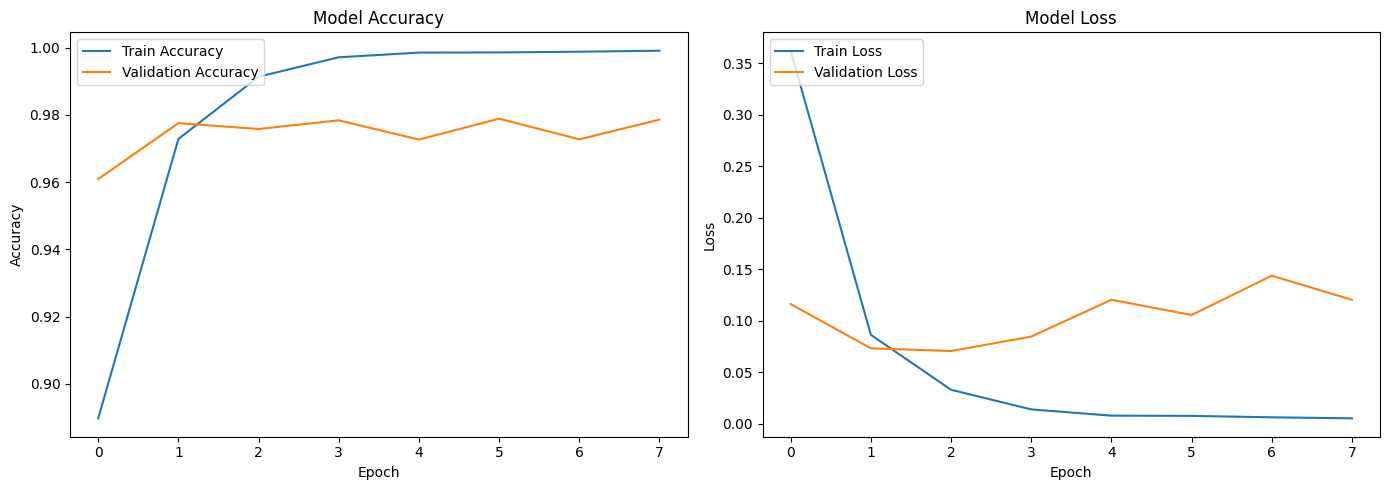

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Đánh giá mô hình 

In [11]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred))

448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Accuracy: 0.975817724350014
Precision: 0.9670150671915297
Recall: 0.9857478898574789
F1-score: 0.9762916266959024
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      7081
           1       0.97      0.99      0.98      7227

    accuracy                           0.98     14308
   macro avg       0.98      0.98      0.98     14308
weighted avg       0.98      0.98      0.98     14308



Vẽ ma trận nhầm lẫn 

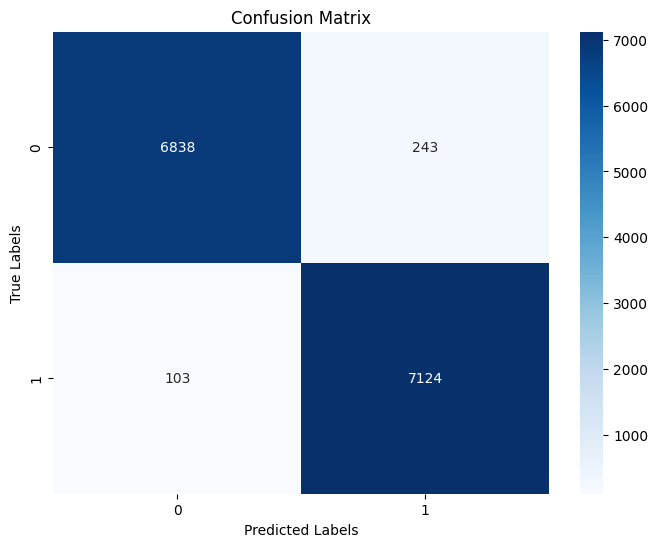

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### SR

Thực hiện tăng cường dữ liệu bằng cách thay thế từ đồng nghĩa (SR)

In [13]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def replace_synonyms(text):
    words = word_tokenize(text)
    replaced_text = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            replaced_text.append(synonym.replace('_', ' '))
        else:
            replaced_text.append(word)
    return ' '.join(replaced_text)

def remove_function_words(text):
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def preprocess_txt(text, use_synonyms=False, use_fwd=False):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    if use_synonyms:
        text = replace_synonyms(text)

    if use_fwd:
        text = remove_function_words(text)

    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens]

    unique_tokens = []
    for token in tokens:
        if token not in unique_tokens:
            unique_tokens.append(token)

    preprocessed_text = ' '.join(unique_tokens)
    return preprocessed_text

df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_txt(x, use_synonyms=True, use_fwd=False) if isinstance(x, str) else "")

X = df['preprocessed_text']
y = df['label']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Word2Vec

In [16]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X]

embedding_dim = 100
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Chuyển văn bản thành chuỗi các chỉ số tương ứng với từ vựng trong Word2Vec
tokenizer = gensim.utils.simple_preprocess  # Sử dụng tokenizer đơn giản của Gensim
X_tokenized = [tokenizer(text) for text in X]

# 8. Chuyển đổi từ vựng thành các chỉ số
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key, start=1)}  # Tạo bảng chỉ số từ
X_encoded = [[word_index[word] for word in sentence if word in word_index] for sentence in X_tokenized]

# Pad các chuỗi để đảm bảo có cùng độ dài
max_len = 200
X_pad = pad_sequences(X_encoded, maxlen=max_len, padding='post')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_train.shape
X_test.shape

(14308, 200)

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (269420, 100)


Xây dựng mô hình 

In [19]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      26,942,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,942,000 (102.78 MB)

 Trainable params: 26,942,000 (102.78 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện mô hình

In [20]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.7348 - loss: 0.7576 - val_accuracy: 0.9333 - val_loss: 0.1860
Epoch 2/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9461 - loss: 0.1587 - val_accuracy: 0.9627 - val_loss: 0.1076
Epoch 3/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.9792 - loss: 0.0685 - val_accuracy: 0.9668 - val_loss: 0.1003
Epoch 4/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9922 - loss: 0.0317 - val_accuracy: 0.9610 - val_loss: 0.1154
Epoch 5/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9955 - loss: 0.0208 - val_accuracy: 0.9712 - val_loss: 0.1074
Epoch 6/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9955 - loss: 0.0200 - val_accuracy: 0.9641 - val_loss: 0.1376
Epoch 7/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9968 - loss: 0.0135 - val_accuracy: 0.9722 - val_loss: 0.1239
Epoch 8/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9976 - loss: 0.0109 - 

Vẽ đồ thị học accuracy và loss 

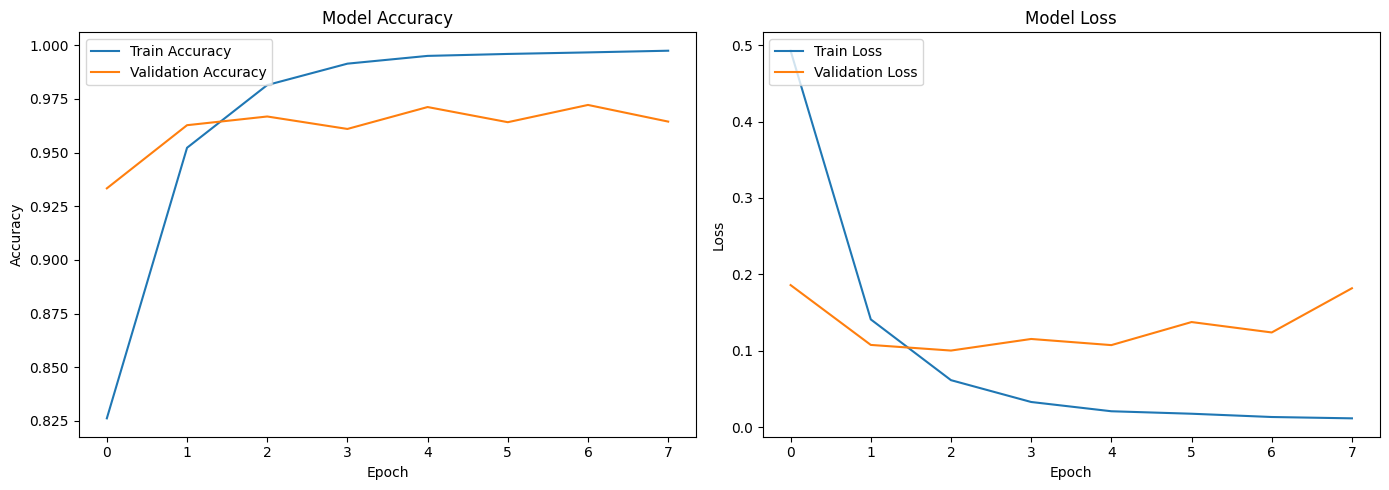

In [21]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Đánh giá mô hình 

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred))

448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Accuracy: 0.9668017892088342
Precision: 0.9861751152073732
Recall: 0.9475577694755777
F1-score: 0.9664808411544704
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7081
           1       0.99      0.95      0.97      7227

    accuracy                           0.97     14308
   macro avg       0.97      0.97      0.97     14308
weighted avg       0.97      0.97      0.97     14308



Vẽ ma trận nhầm lẫn 

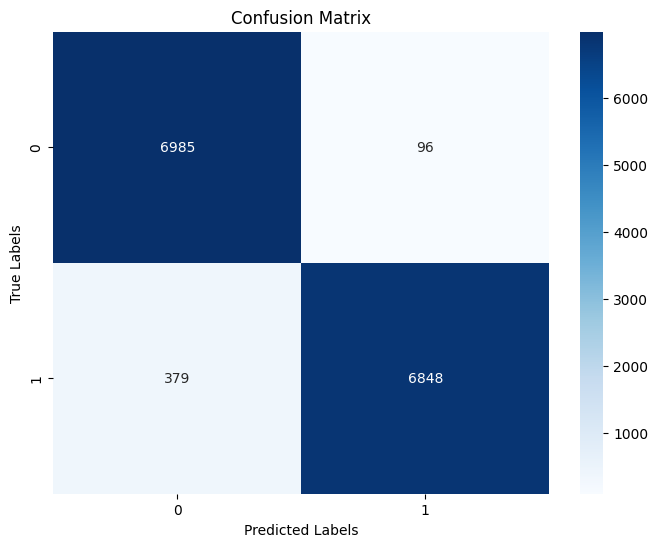

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### FWD

Thực hiện tăng cường dữ liệu xóa các từ không cần thiết (FWD)

In [24]:
df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_txt(x, use_synonyms=False, use_fwd=True) if isinstance(x, str) else "")

X = df['preprocessed_text']
y = df['label']

Word2Vec

In [25]:
sentences = [sentence.split() for sentence in X]

embedding_dim = 100
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

tokenizer = gensim.utils.simple_preprocess
X_tokenized = [tokenizer(text) for text in X]

word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key, start=1)}
X_encoded = [[word_index[word] for word in sentence if word in word_index] for sentence in X_tokenized]

max_len = 200
X_pad = pad_sequences(X_encoded, maxlen=max_len, padding='post')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)
X_train.shape
X_test.shape

(14308, 200)

In [27]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (275845, 100)


Xây dựng mô hình 

In [28]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      27,584,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,584,500 (105.23 MB)

 Trainable params: 27,584,500 (105.23 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện mô hình 

In [29]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.6711 - loss: 0.8898 - val_accuracy: 0.8507 - val_loss: 0.3693
Epoch 2/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.9367 - loss: 0.1901 - val_accuracy: 0.9447 - val_loss: 0.1875
Epoch 3/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9787 - loss: 0.0692 - val_accuracy: 0.9756 - val_loss: 0.0734
Epoch 4/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9922 - loss: 0.0308 - val_accuracy: 0.9763 - val_loss: 0.0857
Epoch 5/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9959 - loss: 0.0189 - val_accuracy: 0.9778 - val_loss: 0.0880
Epoch 6/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9967 - loss: 0.0148 - val_accuracy: 0.9733 - val_loss: 0.1309
Epoch 7/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9976 - loss: 0.0109 - val_accuracy: 0.9773 - val_loss: 0.1183
Epoch 8/20
895/895 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9971 - loss: 0.0120 - 

Vẽ đồ thị học accuracy và loss 

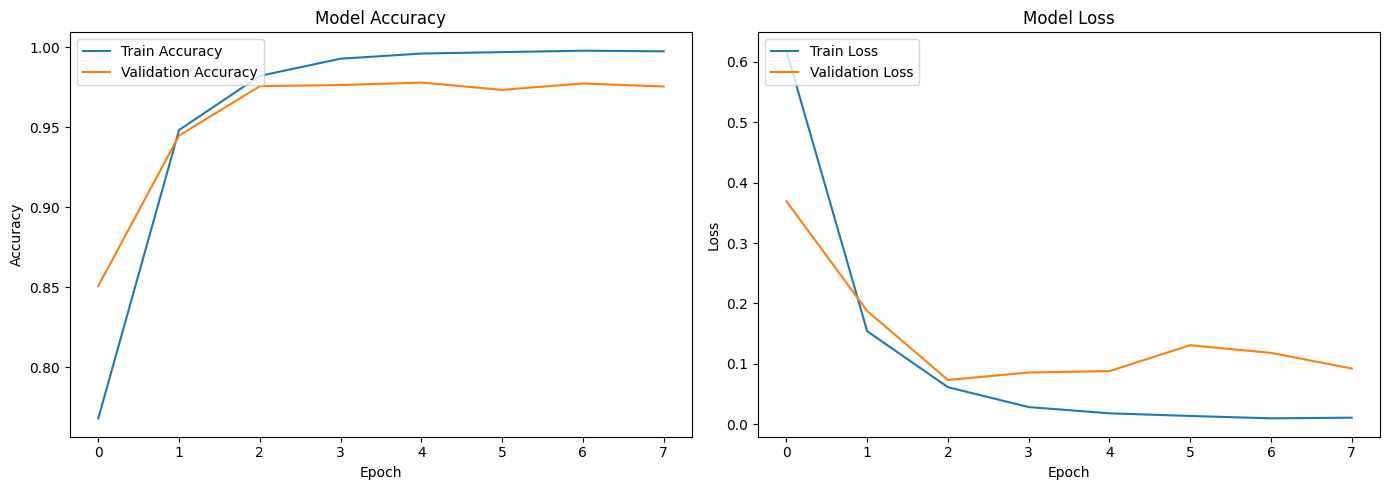

In [30]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Đánh giá mô hình 

In [31]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred))

448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Accuracy: 0.9756080514397539
Precision: 0.9730398899587345
Recall: 0.9788293897882939
F1-score: 0.9759260536662758
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      7081
           1       0.97      0.98      0.98      7227

    accuracy                           0.98     14308
   macro avg       0.98      0.98      0.98     14308
weighted avg       0.98      0.98      0.98     14308



Vẽ ma trận nhầm lẫn 

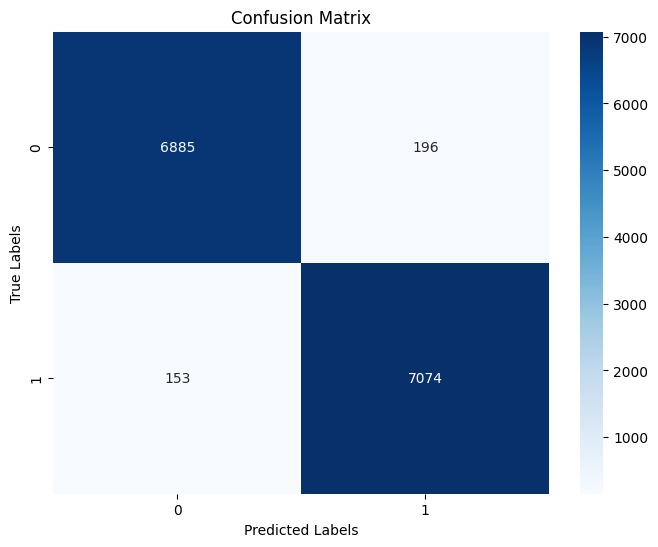

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()